Import required libraries

In [18]:
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from skimage import exposure
from skimage.segmentation import chan_vese, clear_border
from skimage import data, io, segmentation, color
from skimage import graph
from skimage.filters import threshold_otsu
from skimage.morphology import closing,disk
from skimage import img_as_ubyte

Initialization label with couter to be used in file name of patches

In [19]:
ferr_c=0
aust_c=0
parlite_c=0
brain_c=0
morten_c=70
MA_c=0

Function used to suitably modify the pathch file

In [20]:
def label_count(label_now):
    global ferr_c
    global parlite_c
    global aust_c
    global morten_c
    global brain_c
    global MA_c
    if label_now=='ferr':
        ferr_c+=1
        return ferr_c
    if label_now=='aust':
        aust_c+=1
        return aust_c
    if label_now=='brain':
        brain_c+=1
        return brain_c
    if label_now=='parlite':
        parlite_c+=1
        return parlite_c
    if label_now=='morten':
        morten_c+=1
        return morten_c
    if label_now=='MA':
        MA_c+=1
        return MA_c

Function to identify largest rectangle bounding box for each phases in the image

In [21]:
cwd = os.getcwd()

def largest_rect_boundingbox(phase_type,img):
    # Find object with the biggest bounding box
    contours, hierarchy = cv.findContours(phase_type, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    mx = (0,0,0,0)      # biggest bounding box so far
    mx_area = 0
    for cont in contours:
        x,y,w,h = cv.boundingRect(cont)
        area = w*h
        if area > mx_area:
            mx = x,y,w,h
            mx_area = area
    x,y,w,h = mx
    if w<128:
        w=200
    if h<128:
        h=200
    roi=phase_type[y:y+h,x:x+w]
    img_roi=img[y:y+h,x:x+w]
    return (roi,img_roi)

### **Segmentation Fuction (Microstructure images segmentation using Chan-Vese)**

In [22]:
def segment(img):
    cwd=os.getcwd()
    cv.imwrite(cwd+"/TempImageStore/testpattern_thresholded_dilated.jpg",img)

    image = imread(cwd+"/TempImageStore/testpattern_thresholded_dilated.jpg",as_gray=True)

    # Phase1
    imcp=image
    # equalize globally and locally
    glob = exposure.equalize_hist(image) * 255

    v = chan_vese(image, mu=0.5, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=50,
                   dt=0.5, init_level_set="checkerboard", extended_output=True)

    b=v[1]
    dfr=np.mean(b)
    print(dfr)
    if dfr>0:
        b=-b
    thresh=threshold_otsu(b)
    b=b>thresh
    b=closing(b,disk(4))
    phase1=b
    phase2=255-b

    if (np.mean(phase1)>0.999):
        phase2=np.ones((img.shape[0],img.shape[1]), np.uint8)
        phase1=np.ones((img.shape[0],img.shape[1]), np.uint8)

    return (glob,phase1,phase2,v[1],v[2])


In [23]:
# Mount your Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#Change the current working directory to Project location
os.chdir('/content/drive/MyDrive/DSAI_Project')

## Verify patch creation with single Image

0.0010207362387611575


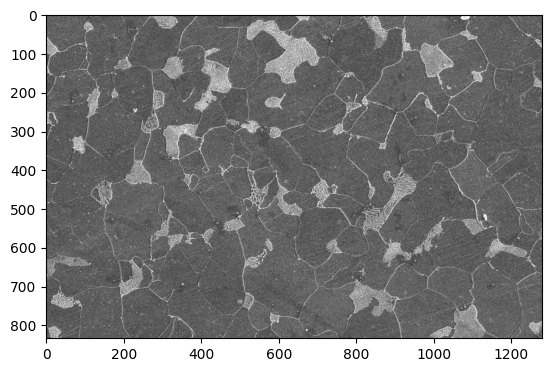

In [ ]:
filename = 'data/1Aimage_m01.jpg'
img=cv.imread(filename,0)
plt.imshow(img,cmap='gray')
glob,phase1,phase2,v1,v2=segment(img)

Displayed Phase 1 (bright region) and masked (dark region)the remaining

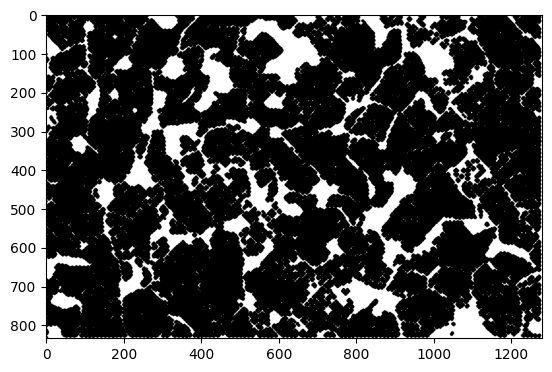

In [ ]:
plt.imshow(phase1,cmap='gray') #yello represents true phase

In [ ]:
img=img_as_ubyte(img)
phase1=img_as_ubyte(phase1)
phase2=255-phase1

Displayed Phase 2 (bright region) and masked(dark region) the remaining

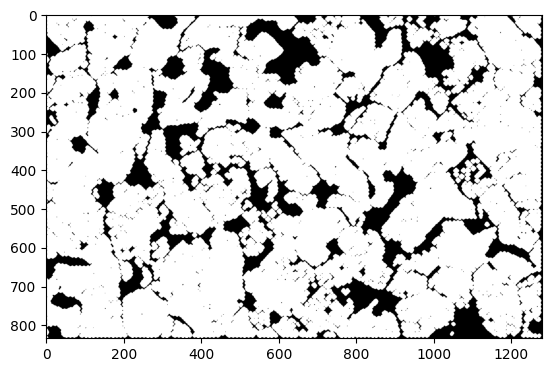

In [ ]:
plt.imshow(phase2, cmap='gray')

In [ ]:
phase1,img1=largest_rect_boundingbox(phase1,img)
phase2,img2=largest_rect_boundingbox(phase2,img)

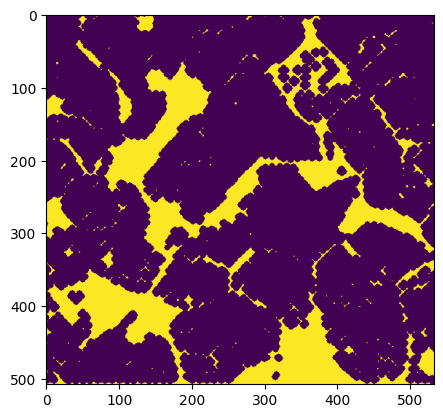

In [ ]:
plt.imshow(phase1)

In [ ]:
phn1='parlite'#'
phn2='ferr' #'morten

In [ ]:
## Cut Patches
cntp1=0
cntp2=0
tcp=10
p1t=250

In [ ]:
xm,ym=phase1.shape
decay=0.9
start_thresh=250
fallout=0
if np.mean(phase1)>2:
    while(cntp1!=tcp and (xm-128)>0 and (ym-128)>0):
        xr=np.random.randint(xm-128)
        yr=np.random.randint(ym-128)
        patch=phase1[yr:yr+128,xr:xr+128]
        # print (np.mean(patch),patch.shape)
        w,h=patch.shape

        if (np.mean(patch)>start_thresh and w==128 and h==128):
            cntp1+=1
            print ("phase1 train patch entered:"+str(cntp1)+"/"+str(tcp))
            glob = exposure.equalize_hist(img1[yr:yr+128,xr:xr+128]) * 255
            cv.imwrite("/content/drive/MyDrive/DSAI_Project/patchData_images/"+phn1+"."+str(label_count(phn1))+".jpg",glob)
        else:
            fallout+=1
            if (fallout>2000):
                fallout=0
                start_thresh=start_thresh*decay

phase1 train patch entered:1/10
phase1 train patch entered:2/10
phase1 train patch entered:3/10
phase1 train patch entered:4/10
phase1 train patch entered:5/10
phase1 train patch entered:6/10
phase1 train patch entered:7/10
phase1 train patch entered:8/10
phase1 train patch entered:9/10
phase1 train patch entered:10/10


In [ ]:
xm,ym=phase2.shape
print(xm,ym)
decay=0.9
start_thresh=255
fallout=0
if np.mean(phase2)>2:
    while(cntp2!=tcp and (xm-128)>0 and (ym-128)>0):
        xr=np.random.randint(xm-128)
        yr=np.random.randint(ym-128)
        patch=phase2[yr:yr+128,xr:xr+128]
        w,h=patch.shape
        if (np.mean(patch)>start_thresh and w==128 and h==128):
            cntp2+=1
            print ("phase2 train patch entered:"+str(cntp2)+"/"+str(tcp))
            glob = exposure.equalize_hist(img2[yr:yr+128,xr:xr+128]) * 255
            cv.imwrite("/content/drive/MyDrive/DSAI_Project/patchData_images/"+phn2+"."+str(label_count(phn2))+".jpg",glob)
        else:
            fallout+=1
            if (fallout>2000):
                fallout=0
                start_thresh=start_thresh*decay

834 1280
phase2 train patch entered:1/10
phase2 train patch entered:2/10
phase2 train patch entered:3/10
phase2 train patch entered:4/10
phase2 train patch entered:5/10
phase2 train patch entered:6/10
phase2 train patch entered:7/10
phase2 train patch entered:8/10
phase2 train patch entered:9/10
phase2 train patch entered:10/10


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## For Batch Images

In [25]:
cwd = os.getcwd()
der=cwd+"/OrgMicrostrucData/"
print (der)
directories=[]
files=[]

/content/drive/MyDrive/DSAI_Project/OrgMicrostrucData/


**Read the image inside OrgMicrostrucData**

In [26]:
for x in os.listdir(der):

    if os.path.isfile(x):
        print ('f-', x)
        files.append(x)

    elif os.path.isdir(x):
        print ('d-', x)
        directories.append(x)

    elif os.path.islink(x):
        print ('l-', x)

    else:
        print ('---', x)
        files.append(x)

print(files)

--- 1Aimage_m03.jpg
--- 1Aimage_m04.jpg
--- 1Aimage_m05.jpg
--- 1Nimage_m05.jpg
--- 1Aimage_m06.jpg
--- 1Nimage_m06.jpg
--- 1Nimage_m02.jpg
--- 1Nimage_m03.jpg
--- 1Aimage_m02.jpg
--- 1Nimage_m04.jpg
--- 1Nimage_m01.jpg
--- 1Aimage_m01.jpg
['1Aimage_m03.jpg', '1Aimage_m04.jpg', '1Aimage_m05.jpg', '1Nimage_m05.jpg', '1Aimage_m06.jpg', '1Nimage_m06.jpg', '1Nimage_m02.jpg', '1Nimage_m03.jpg', '1Aimage_m02.jpg', '1Nimage_m04.jpg', '1Nimage_m01.jpg', '1Aimage_m01.jpg']


### Creation of patches for all imgaes loaded in previous Shell

In [27]:
for ty in range(0,len(files)):

    print ("**********************************************")
    print ("Files Processed:"+str(ty)+"/"+str(len(files)))
    print ("**********************************************")

    # Rule Set for Labels
    cast=files[ty][1:2]
    print(cast)

    if cast=='Q':
        phn1='morten'
        phn2='aust'
    if cast=='A' or cast=='N':
        phn1='parlite'
        phn2='ferr'
    if cast=='F':
        phn1='ferr'
        phn2='ferr'
    if cast=='I':
        phn1='brain'
        phn2='aust'
    if cast=='B':
        phn1='brain'
        phn2='MA'
    if cast=='C':
        phn1='ferr'
        phn2='parlite'

    filename = der+files[ty]
    ft=filename

    img=cv.imread(ft,0)
    glob,phase1,phase2,v1,v2=segment(img)

    ## Cut Patches form the microstructure image
    cntp1=0
    cntp2=0
    tcp=3
    p1t=250

    img=img_as_ubyte(img)
    phase1=img_as_ubyte(phase1)
    phase2=255-phase1

    phase1,img1=largest_rect_boundingbox(phase1,img)
    # cv.imwrite(cwd+'/Results/Image_crop_1.jpg',img1)
    phase2,img2=largest_rect_boundingbox(phase2,img)
    # cv.imwrite(cwd+'/Results/Image_crop_2.jpg',img2)

    # Satrt creation of patches for phase 1
    xm,ym=phase1.shape
    decay=0.9
    start_thresh=250
    fallout=0
    if np.mean(phase1)>2:
        while(cntp1!=tcp and (xm-128)>0 and (ym-128)>0):
            xr=np.random.randint(xm-128)
            yr=np.random.randint(ym-128)
            patch=phase1[yr:yr+128,xr:xr+128]
            # print (np.mean(patch),patch.shape)
            w,h=patch.shape

            if (np.mean(patch)>start_thresh and w==128 and h==128):
                cntp1+=1
                print ("phase1 train patch entered:"+str(cntp1)+"/"+str(tcp))
                glob = exposure.equalize_hist(img1[yr:yr+128,xr:xr+128]) * 255
                cv.imwrite(cwd+"/PatchData_images/"+phn1+"."+str(label_count(phn1))+".jpg",glob)
            else:
                fallout+=1
                if (fallout>2000):
                    fallout=0
                    start_thresh=start_thresh*decay

    # Start creation of patches for phase 2
    xm,ym=phase2.shape
    print(xm,ym)
    decay=0.9
    start_thresh=250
    fallout=0
    if np.mean(phase2)>2:
        while(cntp2!=tcp and (xm-128)>0 and (ym-128)>0):
            xr=np.random.randint(xm-128)
            yr=np.random.randint(ym-128)
            patch=phase2[yr:yr+128,xr:xr+128]
            w,h=patch.shape
            if (np.mean(patch)>start_thresh and w==128 and h==128):
                cntp2+=1
                print ("phase2 train patch entered:"+str(cntp2)+"/"+str(tcp))
                glob = exposure.equalize_hist(img2[yr:yr+128,xr:xr+128]) * 255
                cv.imwrite(cwd+"/PatchData_images/"+phn2+"."+str(label_count(phn2))+".jpg",glob)
            else:
                fallout+=1
                if (fallout>2000):
                    fallout=0
                    start_thresh=start_thresh*decay

print("DATA GENERATION HAS ENDED. YOU MAY TRAIN NOW AFTER COPYING AS MANY TRAIN IMAGES TO <Validate> FOLDER")

**********************************************
Files Processed:0/12
**********************************************
A
-0.0010746215456739693


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
836 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:1/12
**********************************************
A
-0.0008650591353384569
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
832 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:2/12
**********************************************
A


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


-0.0013831774066249759
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
834 945
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:3/12
**********************************************
N
-0.0016375169713152887


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
834 1204
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:4/12
**********************************************
A
-0.0016536546774184938


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
836 986
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:5/12
**********************************************
N
0.0011963749239783258
phase1 train patch entered:1/3
phase1 train patch entered:2/3


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


phase1 train patch entered:3/3
832 1274
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:6/12
**********************************************
N
-0.002033120879581646
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
836 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:7/12
**********************************************
N


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.0016790533146689391
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
836 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:8/12
**********************************************
A


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


-0.001199068526000386


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
836 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:9/12
**********************************************
N
0.00142392471213829
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
834 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
**********************************************
Files Processed:10/12
**********************************************
N


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.001634900300358901
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
834 1038
phase2 train patch entered:1/3
phase2 train patch entered:2/3


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


phase2 train patch entered:3/3
**********************************************
Files Processed:11/12
**********************************************
A
0.0010207362387611575
phase1 train patch entered:1/3
phase1 train patch entered:2/3
phase1 train patch entered:3/3
834 1280
phase2 train patch entered:1/3
phase2 train patch entered:2/3
phase2 train patch entered:3/3
DATA GENERATION HAS ENDED. YOU MAY TRAIN NOW AFTER COPYING AS MANY TRAIN IMAGES TO <Validate> FOLDER


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
